In [1]:
import torch
import torch.nn as nn
import os
import pandas as pd
from transformers import BertModel, BertTokenizer
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 多模态融合模型
class MultimodalModel(nn.Module):
    # 复杂模型
    '''
    def __init__(self, text_model_name='bert-base-uncased', img_model_name='resnet50', num_classes=3):
        super(MultimodalModel, self).__init__()
        # 文本特征提取
        self.text_model = BertModel.from_pretrained(text_model_name)
        self.text_fc = nn.Linear(768, 256)  # BERT 输出维度为 768
        # 图像特征提取
        self.img_model = resnet50(pretrained=True)
        self.img_model.fc = nn.Linear(self.img_model.fc.in_features, 256)  # ResNet 输出维度为 256
        # 多模态融合
        self.fusion_fc = nn.Linear(256 + 256, 128)  # 拼接后的特征维度
        # Dropout 层
        self.dropout = nn.Dropout(0.5)  # 添加 Dropout
        # 分类器
        self.classifier = nn.Linear(128, num_classes)
    '''
    
    # 简单模型
    def __init__(self, text_model_name='bert-base-uncased', img_model_name='resnet50', num_classes=3):
        super(MultimodalModel, self).__init__()
        # 文本特征提取
        self.text_model = BertModel.from_pretrained(text_model_name)
        self.text_fc = nn.Linear(768, 128)  # 减少维度
        # 图像特征提取
        self.img_model = resnet50(pretrained=True)
        self.img_model.fc = nn.Linear(self.img_model.fc.in_features, 128)  # 减少维度
        # 多模态融合
        self.fusion_fc = nn.Linear(128 + 128, 64)  # 减少维度
        # Dropout 层
        self.dropout = nn.Dropout(0.5)
        # 分类器
        self.classifier = nn.Linear(64, num_classes)

    

    def forward(self, text_input, img_input):
        # 文本特征
        text_features = self.text_model(**text_input).last_hidden_state[:, 0, :]  # 取 [CLS] 向量
        text_features = self.text_fc(text_features)
        # 图像特征
        img_features = self.img_model(img_input)
        # 特征融合
        fused_features = torch.cat((text_features, img_features), dim=1)
        fused_features = self.fusion_fc(fused_features)
        # Dropout
        fused_features = self.dropout(fused_features) 
        # 分类
        logits = self.classifier(fused_features)
        return logits


# 自定义数据集
class MultimodalDataset:
    def __init__(self, texts, images, labels, tokenizer, transform):
        self.texts = texts
        self.images = images
        self.labels = labels
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        # 文本编码
        text_input = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
        # 图像预处理
        image = self.transform(image)
        return text_input, image, label




In [2]:
# 训练函数
def train(model, dataloader, optimizer, criterion, device):
    model.train()  
    total_loss = 0
    correct = 0
    total = 0

    for text_input, image, label in dataloader:
        # 将数据移动到设备（GPU 或 CPU）
        text_input = {key: value.squeeze(1).to(device) for key, value in text_input.items()}
        image = image.to(device)
        label = label.to(device)

        # 前向传播
        optimizer.zero_grad()
        logits = model(text_input, image)
        loss = criterion(logits, label)
        
        # 反向传播
        loss.backward()
        optimizer.step()

        # 计算损失和准确率
        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct += (predicted == label).sum().item()
        total += label.size(0)

    # 计算平均损失和准确率
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# 验证函数
def validate(model, dataloader, criterion, device):
    model.eval() 
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # 禁用梯度计算
        for text_input, image, label in dataloader:
            # 将数据移动到设备
            text_input = {key: value.squeeze(1).to(device) for key, value in text_input.items()}
            image = image.to(device)
            label = label.to(device)

            # 前向传播
            logits = model(text_input, image)
            loss = criterion(logits, label)

            # 计算损失和准确率
            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)

    # 计算平均损失和准确率
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

cuda


/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/6
Train Loss: 0.9396, Train Accuracy: 0.5897
Validation Loss: 0.8919, Validation Accuracy: 0.6038
--------------------------------------------------
Epoch 2/6
Train Loss: 0.8705, Train Accuracy: 0.5934
Validation Loss: 0.8509, Validation Accuracy: 0.6038
--------------------------------------------------
Epoch 3/6
Train Loss: 0.8206, Train Accuracy: 0.6159
Validation Loss: 0.7863, Validation Accuracy: 0.6450
--------------------------------------------------
Epoch 4/6
Train Loss: 0.7414, Train Accuracy: 0.6934
Validation Loss: 0.7141, Validation Accuracy: 0.7063
--------------------------------------------------
Epoch 5/6
Train Loss: 0.6632, Train Accuracy: 0.7328
Validation Loss: 0.6754, Validation Accuracy: 0.7175
--------------------------------------------------
Epoch 6/6
Train Loss: 0.5896, Train Accuracy: 0.7744
Validation Loss: 0.6474, Validation Accuracy: 0.7375
--------------------------------------------------


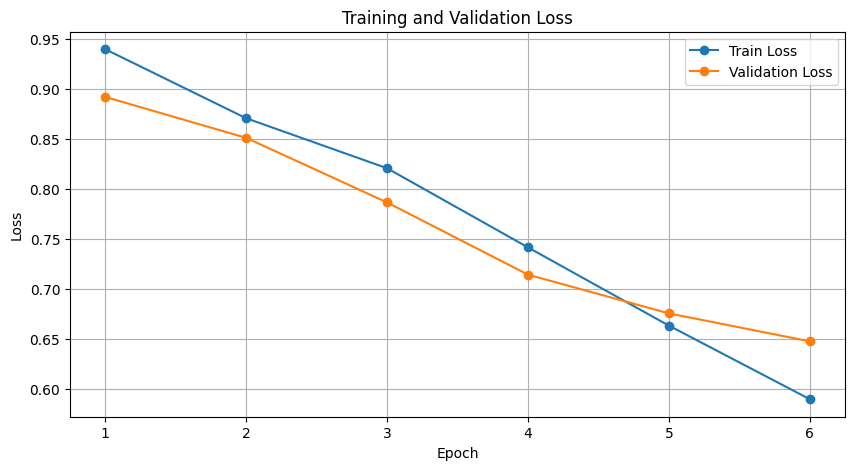

In [3]:
# 定义需要尝试的编码方式列表
ENCODINGS_TO_TRY = [
    'utf-8', 'ascii', 'gbk', 'big5', 'iso-8859-1', 'iso-8859-9',
    'windows-1251', 'windows-1252', 'windows-1253', 'windows-1254',
    'ibm866', 'koi8-r', 'tis-620', 'euc-jp', 'macroman'
]

# 加载 train.txt 文件
train_df = pd.read_csv('train.txt')

# 初始化 lists
texts = []
images = []
labels = []

# 遍历 train.txt 中的每一行
for guid, tag in train_df.values:
    # 加载文本
    text_path = os.path.join('data', f'{guid}.txt')
    
    # 检查文件是否存在
    if not os.path.exists(text_path):
        print(f"File not found: {text_path}")
        continue
    
    # 尝试多种编码方式读取文件
    text = None
    for encoding in ENCODINGS_TO_TRY:
        try:
            with open(text_path, 'r', encoding=encoding) as f:
                text = f.read().strip()
            break  
        except UnicodeDecodeError:
            continue
    
    # 如果所有编码方式都失败，记录错误并跳过该文件
    if text is None:
        print(f"Failed to read file {text_path} with all tried encodings.")
        continue
    
    texts.append(text)
    
    # 加载图像路径
    image_path = os.path.join('data', f'{guid}.jpg')
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        continue
    images.append(image_path)
    
    # 加载标签
    labels.append(tag)

# 标签编码
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)  # 转换为 0, 1, 2

# 划分训练集和验证集
train_texts, val_texts, train_images, val_images, train_labels, val_labels = train_test_split(
    texts, images, labels, test_size=0.2, random_state=42
)

# 数据预处理
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomRotation(10),  # 随机旋转
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 超参数选择
batch_size = 128
learning_rate = 8e-6
num_epochs = 6

# 构建 DataLoader
train_dataset = MultimodalDataset(train_texts, train_images, train_labels, tokenizer, transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = MultimodalDataset(val_texts, val_images, val_labels, tokenizer, transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 设备设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# 初始化模型
model = MultimodalModel().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # 添加权重衰减

# 定义学习率调度器
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# 记录训练和验证损失
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # 训练
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
    train_losses.append(train_loss)
    
    # 验证
    val_loss, val_acc = validate(model, val_dataloader, criterion, device)
    val_losses.append(val_loss)
    
    # 打印结果
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    print("-" * 50)

    # 更新学习率
    scheduler.step(val_loss)

# 保存模型
torch.save(model.state_dict(), 'multimodal_model.pth')

# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.savefig('multimodal_loss_curve.png', dpi=300, bbox_inches='tight')  # 保存为图片
plt.show()

In [4]:
# 加载测试集数据
test_df = pd.read_csv('test_without_label.txt')
test_texts = []
test_images = []

# 遍历 test_without_label.txt 中的每一行
for guid, tag in test_df.values:
    # 加载文本
    guid = int(guid)  # 将 guid 转换为整数
    text_path = os.path.join('data', f'{guid}.txt')
    
    # 检查文件是否存在
    if not os.path.exists(text_path):
        print(f"File not found: {text_path}")
        continue
    
    # 尝试多种编码方式读取文件
    text = None
    for encoding in ENCODINGS_TO_TRY:
        try:
            with open(text_path, 'r', encoding=encoding) as f:
                text = f.read().strip()
            break  
        except UnicodeDecodeError:
            continue
    
    # 如果所有编码方式都失败，记录错误并跳过该文件
    if text is None:
        print(f"Failed to read file {text_path} with all tried encodings.")
        continue
    
    test_texts.append(text)
    
    # 加载图像路径
    image_path = os.path.join('data', f'{guid}.jpg')
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        continue
    test_images.append(image_path)
    

# 构建测试集 DataLoader
test_dataset = MultimodalDataset(test_texts, test_images, [0] * len(test_texts), tokenizer, transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 加载训练好的模型
model.load_state_dict(torch.load('multimodal_model.pth'))
model.eval()

# 预测
predictions = []
with torch.no_grad():
    for text_input, image, _ in test_dataloader:
        text_input = {key: value.squeeze(1).to(device) for key, value in text_input.items()}
        image = image.to(device)
        logits = model(text_input, image)
        _, predicted = torch.max(logits, 1)
        predictions.extend(predicted.cpu().numpy())

# 将预测结果转换为标签
predicted_labels = label_encoder.inverse_transform(predictions)

# 保存结果
test_df['tag'] = predicted_labels
test_df.to_csv('results.txt', index=False)

/tmp/ipykernel_107747/3567792411.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('multimodal_model.pth'))
